In [152]:
import glob,os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [153]:
#pip install statsmodels

In [154]:
path = "data/"
allFiles = glob.glob(os.path.join(path, "*.csv"))
np_array_list = []
for file_ in allFiles:
    df = pd.read_csv(file_,index_col=None, header= 0)
    # get symbol name file
    df['Symbol'] = (file_.split('\\')[1]).split(".")[0]
#     print(df)
#     # pull only needed fields 
    df =df[['Symbol','Date','Adj Close']]
    np_array_list.append(df.as_matrix())
    
# # stack all arrays and transfer it into a data frame
comb_np_array = np.vstack(np_array_list)
# simplify column names
stock_data_raw = pd.DataFrame(comb_np_array, columns = ['Symbol','Date','Close'])
#fix datetime data
stock_data_raw['Date'] = pd.to_datetime(stock_data_raw['Date'], infer_datetime_format = True)
stock_data_raw['Date'] = stock_data_raw['Date'].dt.date

# check for NAs
stock_data_raw = stock_data_raw.pivot('Date','Symbol')
stock_data_raw.columns= stock_data_raw.columns.droplevel()

# collect correct header names (actual stocks)
column_names = list(stock_data_raw)
    
stock_data_raw.tail()

C:\Users\YASHA\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # This is added back by InteractiveShellApp.init_path()


Symbol,FDX,KO,PEP,UPS
Date,,,,
2018-07-12,228.707,42.9142,107.328,103.205
2018-07-13,229.749,42.9815,108.444,103.624
2018-07-16,226.24,42.9719,108.704,105.221
2018-07-17,227.193,43.4714,110.552,105.621
2018-07-18,232.147,43.3465,110.504,106.657


In [155]:
# # hack to remove multi-index stuff
# stock_data_raw= df[['Symbol','Date','Close']]
# stock_data_raw= stock_data_raw.pivot('Date','Symbol')
# stock_data_raw.columns= stock_data_raw.columns.droplevel(-1)
# stock_data_raw.columns= column_names

# # repalce NaNs with previous value
# stock_data_raw.fillna(method = 'bfill', inplace = True)
# stock_data_raw.tail()

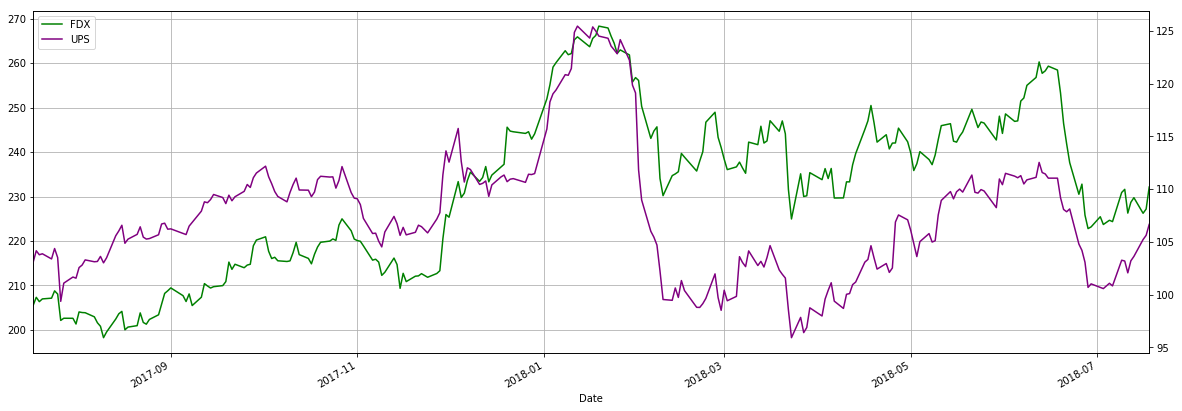

In [156]:
plt.figure(figsize=(20,7))
ax1 = stock_data_raw['FDX'].plot(color='green',grid=True, label='FDX')
ax2 = stock_data_raw['UPS'].plot(color='purple',grid=True, secondary_y = True, label = 'UPS')
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()

plt.legend(h1+h2, l1+l2, loc = 2)
plt.show()

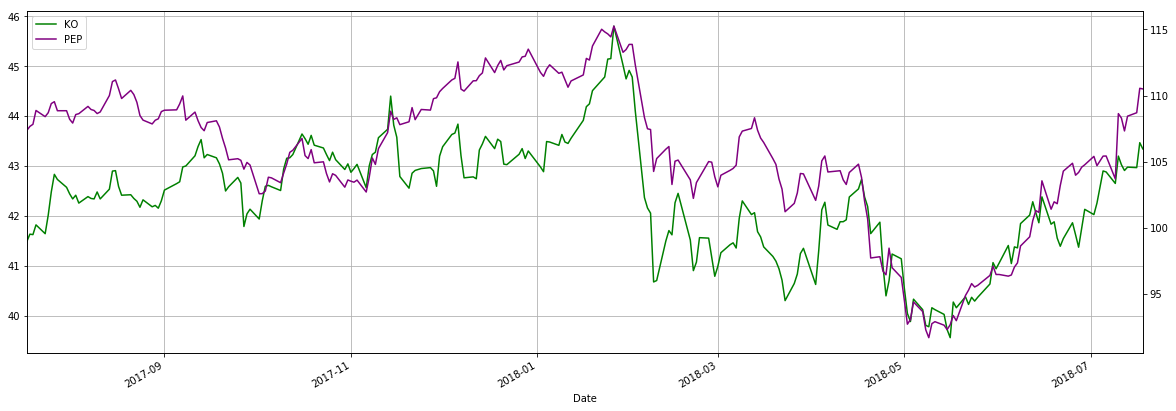

In [157]:
plt.figure(figsize=(20,7))
ax1 = stock_data_raw['KO'].plot(color='green',grid=True, label='KO')
ax2 = stock_data_raw['PEP'].plot(color='purple',grid=True, secondary_y = True, label = 'PEP')
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()

plt.legend(h1+h2, l1+l2, loc = 2)
plt.show()

In order to compare between differently priced assets we need to normalize the data

percentage change
a simple way to transform price data into percentage change applying rolling sum known as cumulative sum.

In [158]:
def normalize_and_accumulate_series(data):
    # take tail to drop head NA
    return data.pct_change().cumsum()
stock_data_raw['FDX'] = normalize_and_accumulate_series(stock_data_raw['FDX'])
stock_data_raw['UPS'] = normalize_and_accumulate_series(stock_data_raw['UPS'])
stock_data_raw['KO'] = normalize_and_accumulate_series(stock_data_raw['KO'])
stock_data_raw['PEP'] = normalize_and_accumulate_series(stock_data_raw['PEP'])

# remove first row with NAs
stock_data_raw = stock_data_raw.tail(len(stock_data_raw)-1)
stock_data_raw.head()

Symbol,FDX,KO,PEP,UPS
Date,,,,
2017-07-19,0.008719,0.003582,0.002869,0.010373
2017-07-20,0.004021,0.003359,0.004343,0.006744
2017-07-21,0.006995,0.008044,0.014039,0.007632
2017-07-24,0.007795,0.003825,0.009752,0.002929
2017-07-25,0.015741,0.012745,0.012508,0.012470


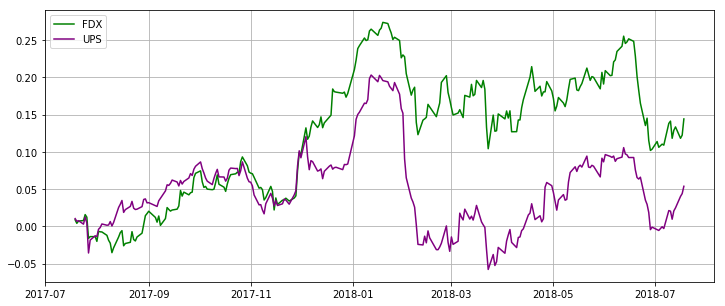

In [142]:
fig, ax = plt.subplots(figsize=(12,5))
plt.plot(stock_data_raw['FDX'], color = 'green', label='FDX')
plt.plot(stock_data_raw['UPS'], color = 'purple', label = 'UPS')
ax.grid(True)
plt.legend(loc=2)
plt.show()

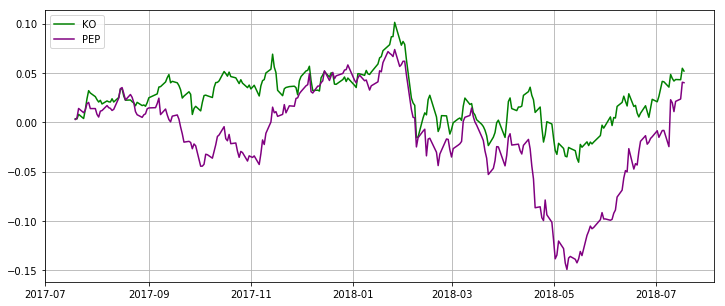

In [143]:
fig, ax = plt.subplots(figsize=(12,5))
plt.plot(stock_data_raw['KO'], color = 'green', label='KO')
plt.plot(stock_data_raw['PEP'], color = 'purple', label = 'PEP')
ax.grid(True)
plt.legend(loc=2)
plt.show()

In [144]:
from statsmodels.tsa.stattools import coint

def corr(data1,data2):
    "data1 & data2 should be numpy array"
    mean1 = data1.mean()
    mean2 = data2.mean()
    std1 = data1.std()
    std2 = data2.std()
    corr = ((data1*data2).mean()-(mean1*mean2))/(std1*std2)
    return corr
    

In [145]:
stock_name_1 = 'KO'
stock_name_2 = 'PEP'

score,pvalue, _ = coint(stock_data_raw[stock_name_1],stock_data_raw[stock_name_2])
correlation = corr(stock_data_raw[stock_name_1],stock_data_raw[stock_name_2])

print('Correlation between %s and %s is %f' % (stock_name_1,stock_name_2,correlation))
print('Cointegration between %s and %s is %f ' % (stock_name_1,stock_name_2,pvalue))

Correlation between KO and PEP is 0.799095
Cointegration between KO and PEP is 0.034550 


In [146]:
stock_name_4 = 'FDX'
stock_name_3 = 'UPS'

score,pvalue, _ = coint(stock_data_raw[stock_name_3],stock_data_raw[stock_name_4])
correlation = corr(stock_data_raw[stock_name_3],stock_data_raw[stock_name_4])

print('Correlation between %s and %s is %f' % (stock_name_3,stock_name_4,correlation))
print('Cointegration between %s and %s is %f ' % (stock_name_3,stock_name_4,pvalue))

Correlation between UPS and FDX is 0.454571
Cointegration between UPS and FDX is 0.206290 


Measuring seperation and skiles highlights

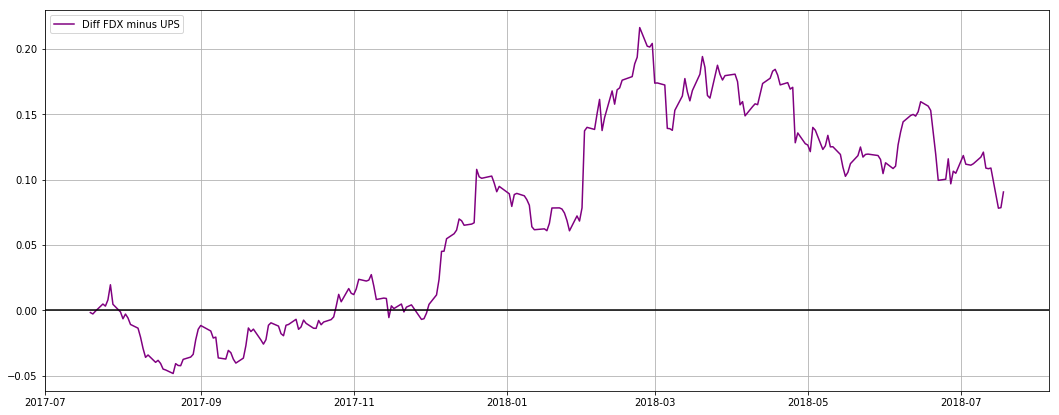

In [147]:
fig, ax = plt.subplots(figsize=(18,7))
plt.plot(stock_data_raw['FDX'] - stock_data_raw['UPS'], color='purple', label='Diff FDX minus UPS')
ax.grid(True)
ax.axhline(y=0, color = 'black', linestyle='-')
plt.legend(loc=2)
plt.show()

Designing spike threshold

In [165]:
def normalize_series(data):
    # take tail to drop head NA
    return data.pct_change()

stock_data_raw['FDX'] = normalize_series(stock_data_raw['FDX'])
stock_data_raw['UPS'] = normalize_series(stock_data_raw['UPS'])
stock_data_raw['KO'] = normalize_series(stock_data_raw['KO'])
stock_data_raw['PEP'] = normalize_series(stock_data_raw['PEP'])

# remove first row with NAs
stock_data_raw = stock_data_raw.tail(len(stock_data_raw)-1)


In [166]:
stock_data_raw.tail() 

Symbol,FDX,KO,PEP,UPS
Date,,,,
2018-07-12,0.090710,-0.060160,-0.453161,1.171273
2018-07-13,0.035311,0.037442,0.960385,0.195613
2018-07-16,-0.114350,-0.005147,0.112854,0.622155
2018-07-17,0.035625,0.269100,0.719408,0.094430
2018-07-18,0.177988,-0.052401,-0.010711,0.223074


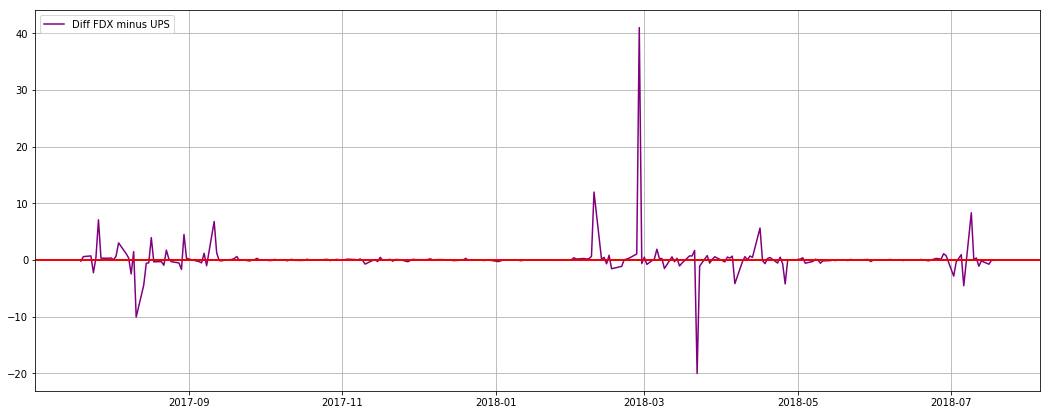

In [167]:
fig, ax = plt.subplots(figsize=(18,7))
plt.plot(stock_data_raw['FDX'] - stock_data_raw['UPS'], color='purple', label='Diff FDX minus UPS')
ax.grid(True)
ax.axhline(y=0, color = 'black', linestyle='-')
ax.axhline(y=0.007, color = 'red', linestyle='-')
ax.axhline(y=-0.007, color = 'red', linestyle='-')
plt.legend(loc=2)
plt.show()

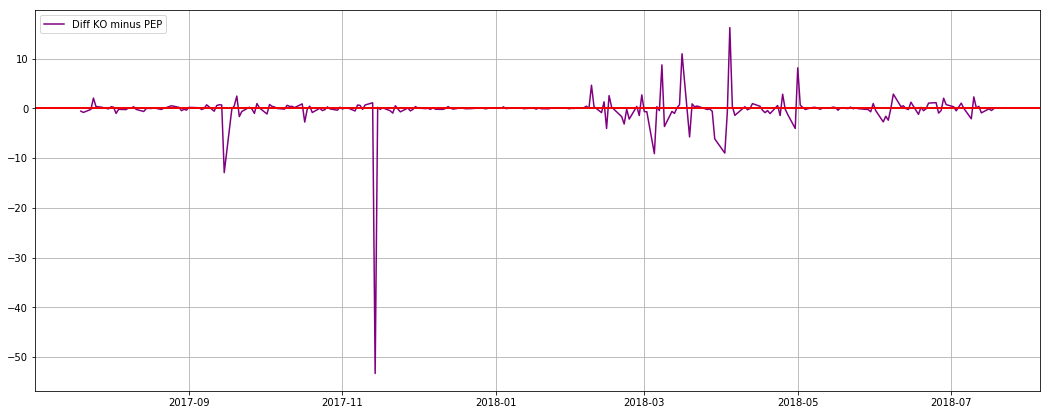

In [168]:
fig, ax = plt.subplots(figsize=(18,7))
plt.plot(stock_data_raw['KO'] - stock_data_raw['PEP'], color='purple', label='Diff KO minus PEP')
ax.grid(True)
ax.axhline(y=0, color = 'black', linestyle='-')
ax.axhline(y=0.02, color = 'red', linestyle='-')
ax.axhline(y=-0.002, color = 'red', linestyle='-')
plt.legend(loc=2)
plt.show()